<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Interpréter des conditions atypiques à l'aide d'autoencodeurs variationnels conditionnels </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Clement GOUBET  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  23 juillet 2019  </b>  </font> </center>
</div>

# Table de contenu

## 0. Préparation de l'environnement de travail
- chargement des modules
- mise en forme des données
- définition de quelques fonctions utiles

## 1. Premier modèle VAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations

## 2. Modèle CVAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations
- analyse spécifique jours fériés et points atypiques

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from tensorflow.keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
#root git folder 
name_model="vae_test"
path_second_folder = "/home/goubetcle/Documents/Git/VAE/"
save_path = "/home/goubetcle/Documents/VAE/"
log_dir_model=save_path+"/logs/Usecase/"
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_second_folder)

In [3]:
import importlib

sys.path.append(path_second_folder+'/src')

import models, loss_class, params_class,AE_blocks,metrics
from models import *
importlib.reload(models)
from loss_class import *
importlib.reload(loss_class)
from params_class import *
importlib.reload(params_class)
import AE_blocks
importlib.reload(AE_blocks)
from callbacks import *
from metrics import *
importlib.reload(metrics)
from utils import *

%load_ext autoreload
%autoreload 2


2021-12-13 16:38:31.226408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 16:38:31.260577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 16:38:31.260780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 16:38:31.261741: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2020. 

In [4]:
# Load dataframe
dataset_csv = os.path.join('data', "dataset_2012_2020.csv")
df_data = pd.read_csv(dataset_csv, sep=";",)
df_data.utc_datetime = pd.to_datetime(df_data.utc_datetime, utc=True)

#Visualize data frame head
df_data.tail(5)

,ds,consumption_France,temperature_France,is_holiday_day,conso_final,day_ahead
87825,2017-12-31 21:30:00,56505.0,9.306475,0.0,56739.0,53500.0
87826,2017-12-31 22:00:00,56000.0,9.097250,0.0,56233.0,53000.0
87827,2017-12-31 22:30:00,56995.0,9.048775,0.0,57239.0,54700.0
87828,2017-12-31 23:00:00,60395.0,9.000300,0.0,60642.0,57300.0
87829,2017-12-31 23:30:00,60230.0,9.000300,0.0,60479.0,57300.0


On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, tout ce qui va être inséré comme entrées du modèle est ici normalisé sur l'ensemble des mesures, puis mis en profils journaliers.

Notre jeu d'entrainement et pour référence est le jeu de données 2012-2018.

In [5]:
ds = pd.DataFrame({"days" : df_data.utc_datetime.dt.date, "minute":df_data.utc_datetime.dt.minute+60*df_data.utc_datetime.dt.hour})

df_conso, df_temp, df_prevision = make_chronics(df=pd.concat([df_data, ds], axis=1),
                                               toshape_columns=["Consommation", "prevision_temp", "prevision_j-1"],
                                               pivot_indexcol="days", pivot_columncol="minute")

df_conso.head()

['consumption_France']


In [6]:
df_conso, conso_scaler = apply_scaler(df_data, column="Consommation", df_chronic=df_conso,
                                      reference_window=df_data.utc_datetime.dt.year <=2018)
df_conso.head()

'df_conso' est constitué des profils journaliers de consommation d'lélectricité que l'on va mettre en entrée de notre VAE

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [7]:
#importation des données calendaires
df_calendar = make_df_calendar(pd.DataFrame({"ds" : pd.to_datetime(np.asarray(df_conso.index))}))

df_holidays = pd.concat([df_data[["is_holidays"]],pd.DataFrame({"ds" : pd.to_datetime(ds.days.values)})], axis=1).drop_duplicates(
                                               subset="ds").reset_index(drop= True)

df_calendar = df_calendar.merge(df_holidays, on="ds", how="left").rename(columns={"is_holidays":"is_holiday_day"})

df_calendar.head(5)


In [8]:
#explicit the potential bridge days taken as extended holidays
day_hol = df_calendar[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

df_calendar['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

,ds,month,weekday,is_weekday,is_holiday_day,year
0,2012-12-28,12,4,1,0.0,2012
1,2012-12-29,12,5,0,0.0,2012
2,2012-12-30,12,6,0,0.0,2012
3,2012-12-31,12,0,1,0.0,2012
4,2013-01-01,1,1,1,1.0,2013
...,...,...,...,...,...,...
1825,2017-12-27,12,2,1,0.0,2017
1826,2017-12-28,12,3,1,0.0,2017
1827,2017-12-29,12,4,1,0.0,2017
1828,2017-12-30,12,5,0,0.0,2017


In [13]:
calendar_factors = ["weekday", "is_weekend", "month", "is_holiday_day"]
factors = df_calendar[calendar_factors].copy()
factorDesc = {ff : 'category' for ff in calendar_factors}

temperatureMean= df_temp.mean(axis=1).values.reshape(-1,1)
factorMatrix = np.c_[factors.values,temperatureMean]
factorDesc['temperature']='regressor'

# Tools to evaluate the representations

In [16]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded, factorMatrix, temperatureMean):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index].ravel(), marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
def prez_3D(x_encoded, factorMatrix, temperatureMean):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [17]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [18]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle

def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(scaler_conso.inverse_transform(x), label = 'truth')
    plt.plot(scaler_conso.inverse_transform(x_hat), '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

## Construire et entrainer un modèle VAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)

In [19]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,48,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = df_conso.shape[1]

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [20]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

On va mettre en forme ici les facteurs sur lesquels on va rendre la représentation latente agnostique. Attention à normaliser les variables quantitatives et à one-hot encoder les variables catégorielles. 

In [21]:
#on va conditionner sur les profils de température et le mois
calendar_cond = ["month"]
condtovae_dims = []
condarray=[]

df_temp, _ = apply_scaler(df_data, column="prevision_temp", df_chronic=df_temp,
                                      reference_window=None)

condarray.append(df_temp.values)
condtovae_dims.append(condarray[-1].shape[1])

for cc in calendar_cond:
    condarray.append(pd.get_dummies(df_calendar[cc], prefix=cc).values)
    condtovae_dims.append(condarray[-1].shape[1])



temperature (1830, 48)
month (1830, 12)
3


In [22]:
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

In [31]:
vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
cond_dims  :=  []
cond_insert  :=  ['encoder', 'decoder']
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
context_dims  :=  None
leapae_dims  :=  [4, None]
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [32]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.cond_dims = condtovae_dims
vae_params.model_params.with_embedding = True
vae_params.model_params.emb_dims = [[48,8],[12,8],6]
vae_params.model_params.nb_encoder_ensemble = 3

In [33]:

def loss_1(y_true, y_pred, latent_mu ,eps=2):
    return tf.math.reduce_sum(K.abs(K.sqrt(K.sum(K.square(latent_mu),axis=-1)) - eps))

custom_loss={"test_0" : {"function" : loss_1,
            "args" :{"latent_mu":"kwargs['latent_components'][0]"} }}

loss_weights = {"recon_loss" : 1,
                "kl_loss" : 0.3,
                "info_loss" : 42,
               "test_0":1}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=custom_loss)
vae_loss.options["log_prior_sigma"] = [-2.,-1.,0.,1]

vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5


In [26]:
new_cae=CVAE(vae_params)
new_cae.VAE_params.__dict__

{'name': 'vae_test',
 'folder': '/home/goubetcle/Documents/VAE//logs/Usecase/vae_test',
 'model_params': <params_class.ModelParams at 0x7fbd303628e0>,
 'training_params': <params_class.TrainingParams at 0x7fbd30362d60>}

In [27]:
new_cae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_inputs (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_0 (InputLayer)     [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_1 (InputLayer)     [(None, 12)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          24478       ['x_inputs[0][0]',               
                                 (None, 4)]                       'cond_inputs_0[0][0]',       

Losses and associated weight involved in the model: 
recon_loss  :  1
kl_loss  :  0.3
info_loss  :  42
test_0  :  1


In [28]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


## START TRAINING ##
Epoch 1/2000
103/103 [==============================] - 3s 9ms/step - loss: 62.0167 - val_loss: 57.5943
Epoch 2/2000
103/103 [==============================] - 1s 6ms/step - loss: 55.6681 - val_loss: 53.3936
Epoch 3/2000
103/103 [==============================] - 1s 6ms/step - loss: 53.0768 - val_loss: 51.0174
Epoch 4/2000
103/103 [==============================] - 1s 6ms/step - loss: 50.2973 - val_loss: 51.0625
Epoch 5/2000
103/103 [==============================] - 1s 6ms/step - loss: 47.8363 - val_loss: 46.9239
Epoch 6/2000
103/103 [==============================] - 1s 6ms/step - loss: 44.8457 - val_loss: 45.0103
Epoch 7/2000
103/103 [==============================] - 1s 6ms/step - loss: 41.6445 - val_loss: 43.2306
Epoch 8/2000
103/103 [==============================] - 1s 7ms/step - loss: 39.4539 - val_loss: 38.7772
Epoch 9/2000
103/103 [==============================] - 1s 6ms/step - loss: 37.0753 - val_loss: 37.2010
Epoch 10/2000
103/103 [====================

103/103 [==============================] - 1s 6ms/step - loss: 5.9236 - val_loss: 5.3709
Epoch 80/2000
103/103 [==============================] - 1s 6ms/step - loss: 5.9040 - val_loss: 5.1852
Epoch 81/2000
103/103 [==============================] - 1s 6ms/step - loss: 5.7874 - val_loss: 5.2692
Epoch 82/2000
103/103 [==============================] - 1s 6ms/step - loss: 5.7610 - val_loss: 5.2442
Epoch 83/2000
103/103 [==============================] - 1s 6ms/step - loss: 5.6713 - val_loss: 5.0142
Epoch 84/2000
103/103 [==============================] - 1s 6ms/step - loss: 5.6055 - val_loss: 5.0428
Epoch 85/2000
103/103 [==============================] - 1s 6ms/step - loss: 5.5180 - val_loss: 4.9803
Epoch 86/2000
103/103 [==============================] - 1s 6ms/step - loss: 5.5376 - val_loss: 5.0091
Epoch 87/2000
103/103 [==============================] - 1s 6ms/step - loss: 5.4917 - val_loss: 4.9609
Epoch 88/2000
103/103 [==============================] - 1s 6ms/step - loss: 5.3928 - v

103/103 [==============================] - 1s 6ms/step - loss: 3.8785 - val_loss: 3.6795
Epoch 159/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.8268 - val_loss: 3.6852
Epoch 160/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.8332 - val_loss: 3.7483
Epoch 161/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.8800 - val_loss: 3.7235
Epoch 162/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.7983 - val_loss: 3.6903
Epoch 163/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.8157 - val_loss: 3.8110
Epoch 164/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.7751 - val_loss: 3.7786
Epoch 165/2000
103/103 [==============================] - 1s 7ms/step - loss: 3.7966 - val_loss: 3.8617
Epoch 166/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.7437 - val_loss: 3.6776
Epoch 167/2000
103/103 [==============================] - 1s 6ms/step - loss: 3

Epoch 237/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.3182 - val_loss: 3.4928
Epoch 238/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.3637 - val_loss: 3.3865
Epoch 239/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.3815 - val_loss: 3.4396
Epoch 240/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.3560 - val_loss: 3.3055
Epoch 241/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.3219 - val_loss: 3.2716
Epoch 242/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.3425 - val_loss: 3.2480
Epoch 243/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.3480 - val_loss: 3.5347
Epoch 244/2000
103/103 [==============================] - 1s 7ms/step - loss: 3.3259 - val_loss: 3.4253
Epoch 245/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.3149 - val_loss: 3.4156
Epoch 246/2000
103/103 [==============================] - 1s 6ms

Epoch 316/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.1324 - val_loss: 3.1644
Epoch 317/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.1404 - val_loss: 3.0977
Epoch 318/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.1100 - val_loss: 3.1054
Epoch 319/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.1434 - val_loss: 3.1065
Epoch 320/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.1156 - val_loss: 3.1555
Epoch 321/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.1175 - val_loss: 3.0075
Epoch 322/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.0816 - val_loss: 3.0548
Epoch 323/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.0870 - val_loss: 3.1924
Epoch 324/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.1065 - val_loss: 3.1068
Epoch 325/2000
103/103 [==============================] - 1s 6ms

Epoch 395/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.9822 - val_loss: 3.0814
Epoch 396/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.0025 - val_loss: 3.0103
Epoch 397/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.9705 - val_loss: 3.0739
Epoch 398/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.9691 - val_loss: 3.0404
Epoch 399/2000
103/103 [==============================] - 1s 6ms/step - loss: 3.0084 - val_loss: 3.0017
Epoch 400/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.9917 - val_loss: 3.0473
Epoch 401/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.9489 - val_loss: 2.9272
Epoch 402/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.9460 - val_loss: 2.9802
Epoch 403/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.9502 - val_loss: 3.0920
Epoch 404/2000
103/103 [==============================] - 1s 6ms

Epoch 474/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.8649 - val_loss: 3.0098
Epoch 475/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.8958 - val_loss: 3.0206
Epoch 476/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.8608 - val_loss: 2.9550
Epoch 477/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.8806 - val_loss: 2.9639
Epoch 478/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.8875 - val_loss: 2.9354
Epoch 479/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.8417 - val_loss: 2.9296
Epoch 480/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.8576 - val_loss: 2.9321
Epoch 481/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.8597 - val_loss: 2.9956
Epoch 482/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.8632 - val_loss: 3.0031
Epoch 483/2000
103/103 [==============================] - 1s 7ms

Epoch 553/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.7702 - val_loss: 2.9255
Epoch 554/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.7809 - val_loss: 2.8471
Epoch 555/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.7901 - val_loss: 2.9214
Epoch 556/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.7751 - val_loss: 2.9223
Epoch 557/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.7656 - val_loss: 2.7601
Epoch 558/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.7647 - val_loss: 2.9043
Epoch 559/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.7965 - val_loss: 2.9199
Epoch 560/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.7888 - val_loss: 2.9941
Epoch 561/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.7683 - val_loss: 2.9527
Epoch 562/2000
103/103 [==============================] - 1s 7ms

Epoch 632/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.7079 - val_loss: 2.9344
Epoch 633/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6915 - val_loss: 2.9207
Epoch 634/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.7099 - val_loss: 2.9279
Epoch 635/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.7469 - val_loss: 2.8442
Epoch 636/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.7253 - val_loss: 2.8891
Epoch 637/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.7516 - val_loss: 2.8424
Epoch 638/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.7438 - val_loss: 2.7285
Epoch 639/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.7022 - val_loss: 2.8785
Epoch 640/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.7127 - val_loss: 2.8277
Epoch 641/2000
103/103 [==============================] - 1s 6ms

Epoch 711/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6752 - val_loss: 2.7437
Epoch 712/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6443 - val_loss: 2.9122
Epoch 713/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6528 - val_loss: 2.7947
Epoch 714/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6855 - val_loss: 2.7731
Epoch 715/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6698 - val_loss: 2.7869
Epoch 716/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6634 - val_loss: 2.8453
Epoch 717/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6733 - val_loss: 2.7737
Epoch 718/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6532 - val_loss: 2.8202
Epoch 719/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6513 - val_loss: 2.8016
Epoch 720/2000
103/103 [==============================] - 1s 6ms

Epoch 790/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6058 - val_loss: 2.7224
Epoch 791/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.6365 - val_loss: 2.8718
Epoch 792/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.6310 - val_loss: 2.7285
Epoch 793/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6169 - val_loss: 2.7661
Epoch 794/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6251 - val_loss: 2.7763
Epoch 795/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6040 - val_loss: 2.7509
Epoch 796/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.6288 - val_loss: 2.6616
Epoch 797/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6097 - val_loss: 2.7762
Epoch 798/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6387 - val_loss: 2.7042
Epoch 799/2000
103/103 [==============================] - 1s 6ms

Epoch 869/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6018 - val_loss: 2.7065
Epoch 870/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5654 - val_loss: 2.7467
Epoch 871/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5569 - val_loss: 2.7612
Epoch 872/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5795 - val_loss: 2.6578
Epoch 873/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.6147 - val_loss: 2.7296
Epoch 874/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5972 - val_loss: 2.6536
Epoch 875/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5674 - val_loss: 2.6673
Epoch 876/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5755 - val_loss: 2.8797
Epoch 877/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5797 - val_loss: 2.8077
Epoch 878/2000
103/103 [==============================] - 1s 6ms

Epoch 948/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.5544 - val_loss: 2.7651
Epoch 949/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5676 - val_loss: 2.6668
Epoch 950/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5879 - val_loss: 2.7208
Epoch 951/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5438 - val_loss: 2.6028
Epoch 952/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5740 - val_loss: 2.6700
Epoch 953/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5523 - val_loss: 2.6659
Epoch 954/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5437 - val_loss: 2.8163
Epoch 955/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5529 - val_loss: 2.6734
Epoch 956/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5350 - val_loss: 2.6681
Epoch 957/2000
103/103 [==============================] - 1s 6ms

103/103 [==============================] - 1s 6ms/step - loss: 2.5311 - val_loss: 2.6803
Epoch 1027/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5392 - val_loss: 2.7408
Epoch 1028/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5605 - val_loss: 2.5983
Epoch 1029/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5274 - val_loss: 2.6162
Epoch 1030/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5175 - val_loss: 2.6275
Epoch 1031/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5135 - val_loss: 2.7526
Epoch 1032/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.4964 - val_loss: 2.8008
Epoch 1033/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5278 - val_loss: 2.7449
Epoch 1034/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5279 - val_loss: 2.6827
Epoch 1035/2000
103/103 [==============================] - 1s 6ms/step 

103/103 [==============================] - 1s 6ms/step - loss: 2.5066 - val_loss: 2.6780
Epoch 1105/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5080 - val_loss: 2.6484
Epoch 1106/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.4782 - val_loss: 2.6006
Epoch 1107/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.4649 - val_loss: 2.6298
Epoch 1108/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.4948 - val_loss: 2.4907
Epoch 1109/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.4824 - val_loss: 2.6993
Epoch 1110/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.4750 - val_loss: 2.6481
Epoch 1111/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.5098 - val_loss: 2.5997
Epoch 1112/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.4936 - val_loss: 2.6604
Epoch 1113/2000
103/103 [==============================] - 1s 6ms/step 

103/103 [==============================] - 1s 6ms/step - loss: 2.4555 - val_loss: 2.6615
Epoch 1183/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.4759 - val_loss: 2.5430
Epoch 1184/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.4642 - val_loss: 2.5342
Epoch 1185/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.4680 - val_loss: 2.6119
Epoch 1186/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.4951 - val_loss: 2.6030
Epoch 1187/2000
103/103 [==============================] - 1s 7ms/step - loss: 2.4638 - val_loss: 2.7550
Epoch 1188/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.4877 - val_loss: 2.5426
Epoch 1189/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.4737 - val_loss: 2.6215
Epoch 1190/2000
103/103 [==============================] - 1s 6ms/step - loss: 2.4544 - val_loss: 2.6020
Epoch 1191/2000
103/103 [==============================] - 1s 7ms/step 

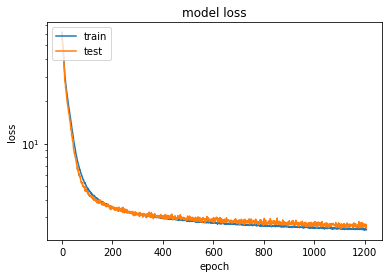

## MODEL SAVED ##


In [29]:
train_set = df_calendar.year.values <= 2018
test_set = df_calendar.year.values == 2019

input_cvae = [df_conso.values[train_set,:]] + [c[train_set,:] for c in condarray]
output_cvae = df_conso.values[train_set,:]

new_cae.train(input_cvae, output_cvae, epochs= 2000, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop])

In [30]:
x_encoded = new_cae.encoder.predict(input_cvae)[0]

Mutual Information Gap : 0.04


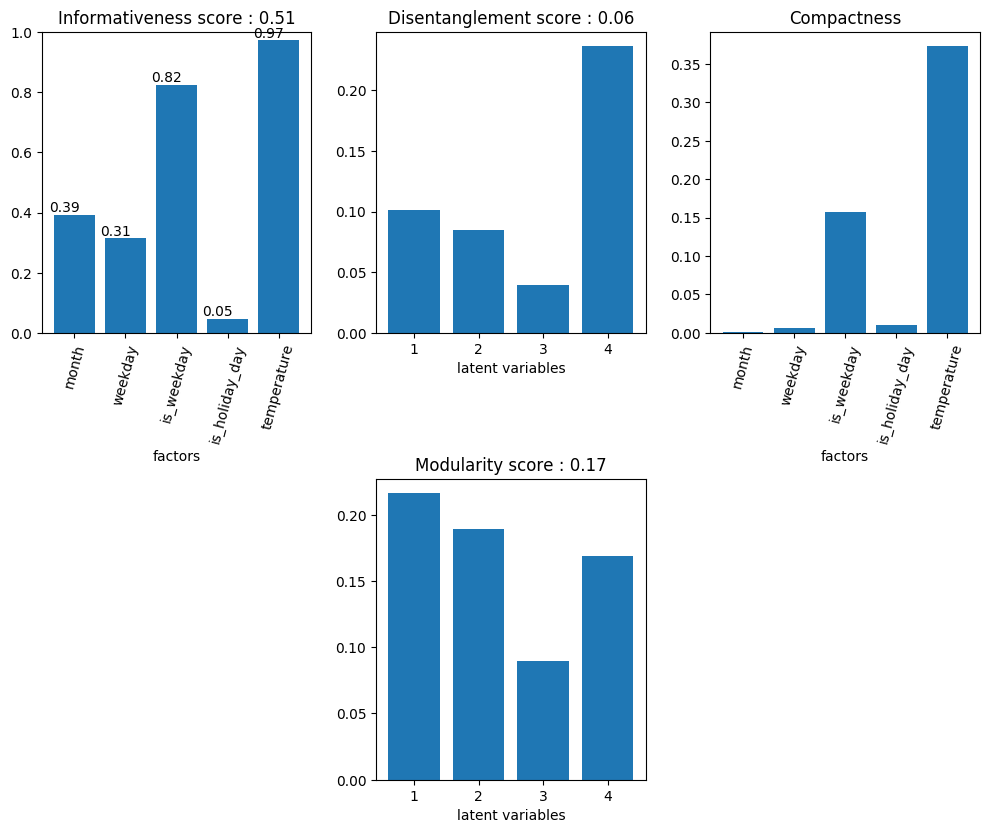

In [31]:
model_eval, importanceMatrix =evaluate_latent_code(x_encoded, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, z_dim, factorDesc)

In [32]:
test_input_cvae = [df_conso.values[test_set,:]] + [c[test_set,:] for c in condarray]

x_hat = new_cae.model.predict(test_input_cvae)

np.mean(np.abs(x_hat - test_input_cvae[0]))

0.8324147970520556

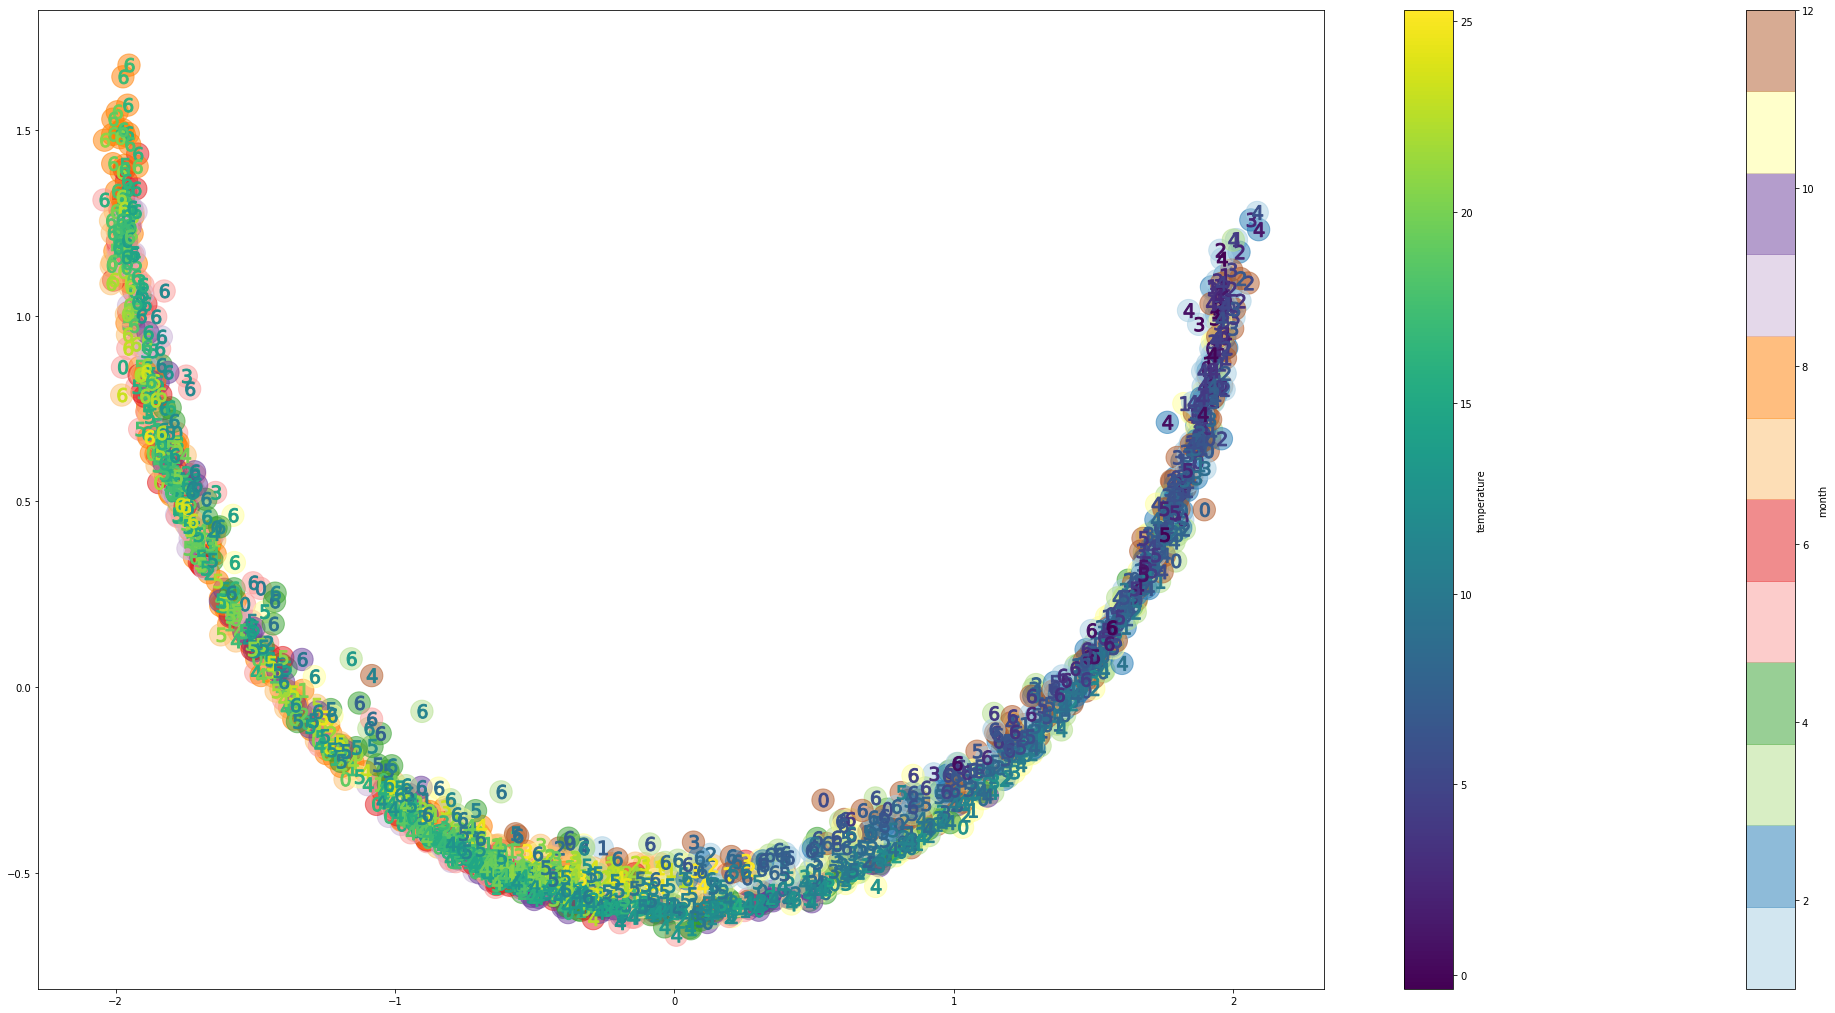

In [33]:
prez_2D(x_encoded, factorMatrix[train_set,:], temperatureMean[train_set])

Mutual Information Gap : 0.07


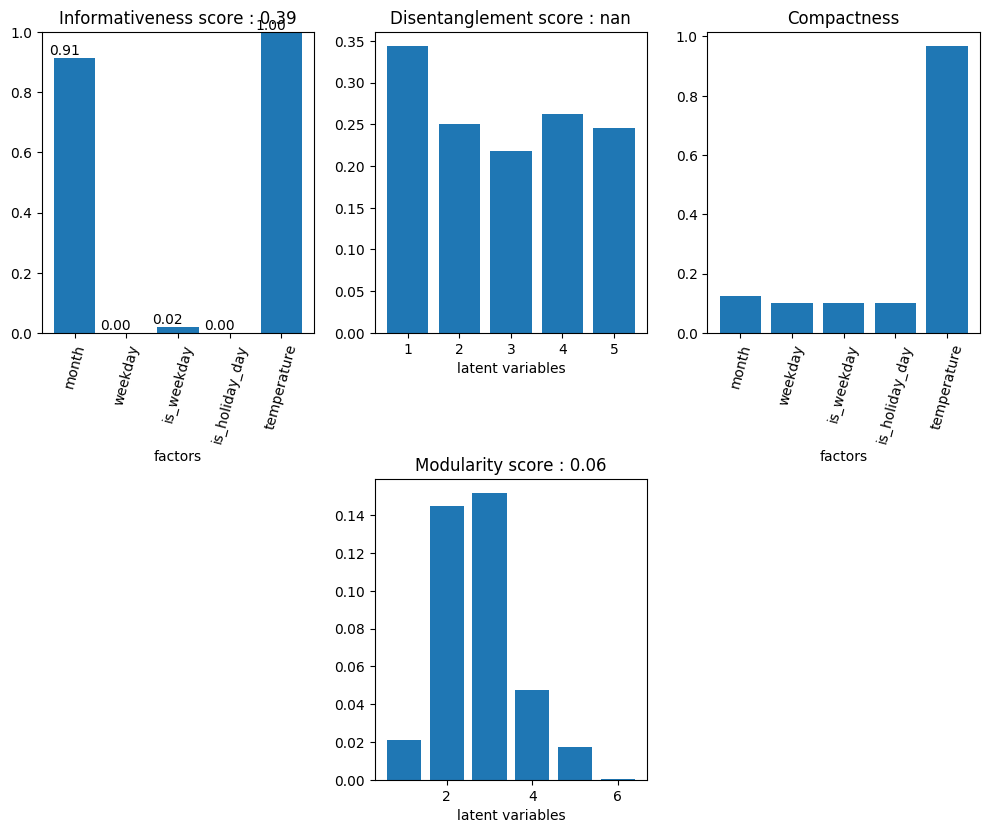

In [34]:
cond_emb = new_cae.cond_embedding.predict(input_cvae[1:])
model_eval, importanceMatrix =evaluate_latent_code(cond_emb, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, cond_emb.shape[1], factorDesc)

## Essai de la loss de mutual info

In [47]:
import callbacks
importlib.reload(callbacks)
from callbacks import *

In [52]:
def affinity_matrix(A):
    d0 = A.shape[0]
    d1 = A.shape[1]
    A_tiled1 = np.tile(A.reshape(d0,1,d1), [1,d0,1])
    A_tiled2 = np.tile(A.reshape(1,d0,d1), [d0,1,1])
    gram_A = np.sqrt(np.sum(np.square(A_tiled1 - A_tiled2 ), axis=-1))

    return gram_A

pca_test=PCA(6)
x_pca = pca_test.fit_transform(input_cvae[0])
y_mat = 1 * (affinity_matrix(x_pca) <=1.5)

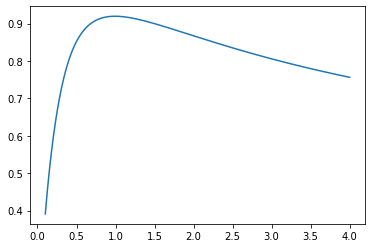

In [53]:
#Trouver le meilleur sigma
sigma = np.linspace(0.1,4, num=300, endpoint=True)

s_test=[]
for s in sigma:
    x_mat = numpy_make_Gram_matrix(input_cvae[0],s)
    
    s_test.append(np.trace(np.matmul(x_mat,y_mat.T))/(np.linalg.norm(x_mat, "fro")*np.linalg.norm(y_mat, "fro")))
sop=sigma[np.argmax(s_test)]
print(sop)
plt.plot(sigma, s_test)

In [23]:
sop = 0.9869565217391304

In [24]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,48,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur

In [25]:
#root git folder 
name_model="cvae_mutualinfo"
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
cond_dims  :=  []
cond_insert  :=  ['encoder', 'decoder']
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
context_dims  :=  None
leapae_dims  :=  [4, None]
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [26]:
condtovae_dims

[48, 12]

In [28]:
len(vae_params.model_params.emb_dims)

0

In [29]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.cond_dims = condtovae_dims
vae_params.model_params.with_embedding = True
vae_params.model_params.emb_dims = [[36,22,10],[12,4],6]
vae_params.model_params.nb_encoder_ensemble = 1


loss_weights = {"recon_loss" : 1, "kl_loss" : 0.3, "info_loss":66}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=None)
vae_loss.options["scale"] = sop
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5

In [30]:
mi_cvae=CVAE(vae_params)
mi_cvae.VAE_params.model_params.cond_insert

['encoder', 'decoder']

In [31]:
mi_cvae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_inputs (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_0 (InputLayer)     [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_1 (InputLayer)     [(None, 12)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          10230       ['x_inputs[0][0]',               
                                 (None, 4)]                       'cond_inputs_0[0][0]',       

Losses and associated weight involved in the model: 
recon_loss  :  1
kl_loss  :  0.3
info_loss  :  66


In [32]:
epochs=500

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=200, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


In [34]:
               
histinfo = InformationHistory(scale=sop,alpha=1.01,dataset_train=input_cvae,
                              cond_insert = mi_cvae.VAE_params.model_params.cond_insert,
                              period=np.unique(np.logspace(0,4,endpoint=True, num=500, dtype=int)),
                              infotoeval=["XZ", "X(C+Z)", "CZ", "CEmb", "XX'"], printlogger=True)

## START TRAINING ##
Mutual informations for epoch 1 are XZ :  -43.703 ; X(C+Z) :  141.170 ; CZ :  10.484 ; CEmb :  48.281 ; XX' :  -32.760
Mutual informations for epoch 2 are XZ :  -45.146 ; X(C+Z) :  141.120 ; CZ :  9.278 ; CEmb :  42.889 ; XX' :  -36.072
Mutual informations for epoch 3 are XZ :  -43.758 ; X(C+Z) :  141.061 ; CZ :  8.182 ; CEmb :  36.951 ; XX' :  -40.136
Mutual informations for epoch 4 are XZ :  -44.066 ; X(C+Z) :  140.988 ; CZ :  7.913 ; CEmb :  34.539 ; XX' :  -38.957
Mutual informations for epoch 5 are XZ :  -43.808 ; X(C+Z) :  140.978 ; CZ :  7.953 ; CEmb :  32.447 ; XX' :  -36.807
Mutual informations for epoch 6 are XZ :  -44.041 ; X(C+Z) :  140.976 ; CZ :  8.461 ; CEmb :  31.215 ; XX' :  -30.536
Mutual informations for epoch 7 are XZ :  -42.443 ; X(C+Z) :  141.011 ; CZ :  8.600 ; CEmb :  28.946 ; XX' :  -33.674
Mutual informations for epoch 8 are XZ :  -41.931 ; X(C+Z) :  141.027 ; CZ :  9.405 ; CEmb :  28.341 ; XX' :  -29.462
Mutual informations for epoch 9 ar

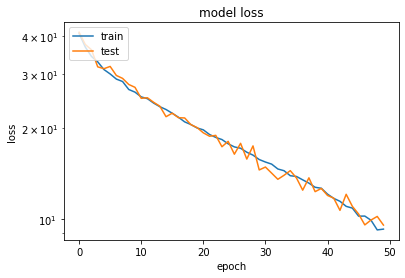

## MODEL SAVED ##


In [35]:
mi_cvae.train(input_cvae, output_cvae, epochs= 50, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop, histinfo])

In [36]:
mi_cvae.maketrainable(modelpart=['encoder'], boolean=True)
mi_cvae.maketrainable(modelpart=['decoder'], boolean=False)
mi_cvae.maketrainable(modelpart=['cond_embedding'], boolean=True)

Change trainable status of encoder layers
Change trainable status of decoder layers
Change trainable status of cond_embedding layers


In [37]:
for lay in mi_cvae.decoder.layers:
    print(lay.trainable)

False
False
False
True
False
False


In [38]:
for i in ['model','encoder', 'decoder', 'cond_embedding']:
    getattr(mi_cvae,i).summary()

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_inputs (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_0 (InputLayer)     [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_1 (InputLayer)     [(None, 12)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          10230       ['x_inputs[0][0]',               
                                 (None, 4)]                       'cond_inputs_0[0][0]',       

## START TRAINING ##
Mutual informations for epoch 51 are XZ :  -6.114 ; X(C+Z) :  144.838 ; CZ :  10.158 ; CEmb :  12.733 ; XX' :  23.288
Mutual informations for epoch 52 are XZ :  -5.661 ; X(C+Z) :  144.849 ; CZ :  10.541 ; CEmb :  12.857 ; XX' :  23.396
Mutual informations for epoch 53 are XZ :  -5.162 ; X(C+Z) :  144.857 ; CZ :  10.861 ; CEmb :  12.813 ; XX' :  23.913
Mutual informations for epoch 54 are XZ :  -4.561 ; X(C+Z) :  144.868 ; CZ :  11.400 ; CEmb :  12.999 ; XX' :  22.830
Mutual informations for epoch 55 are XZ :  -4.016 ; X(C+Z) :  144.884 ; CZ :  11.946 ; CEmb :  13.230 ; XX' :  24.193
Mutual informations for epoch 56 are XZ :  -3.495 ; X(C+Z) :  144.897 ; CZ :  12.270 ; CEmb :  13.320 ; XX' :  25.877
Mutual informations for epoch 58 are XZ :  -2.847 ; X(C+Z) :  144.915 ; CZ :  12.573 ; CEmb :  13.298 ; XX' :  25.357
Mutual informations for epoch 59 are XZ :  -2.499 ; X(C+Z) :  144.924 ; CZ :  12.823 ; CEmb :  13.491 ; XX' :  28.538
Mutual informations for epoch 60 ar

Mutual informations for epoch 189 are XZ :  4.658 ; X(C+Z) :  145.399 ; CZ :  12.573 ; CEmb :  10.226 ; XX' :  38.283
Mutual informations for epoch 192 are XZ :  4.775 ; X(C+Z) :  145.412 ; CZ :  12.575 ; CEmb :  10.091 ; XX' :  37.284
Mutual informations for epoch 196 are XZ :  4.778 ; X(C+Z) :  145.412 ; CZ :  12.502 ; CEmb :  9.945 ; XX' :  37.180
Mutual informations for epoch 199 are XZ :  4.988 ; X(C+Z) :  145.431 ; CZ :  12.823 ; CEmb :  10.096 ; XX' :  37.683
Mutual informations for epoch 203 are XZ :  4.915 ; X(C+Z) :  145.439 ; CZ :  12.730 ; CEmb :  9.955 ; XX' :  36.424
Mutual informations for epoch 207 are XZ :  5.062 ; X(C+Z) :  145.435 ; CZ :  12.668 ; CEmb :  9.837 ; XX' :  37.940
Mutual informations for epoch 211 are XZ :  5.179 ; X(C+Z) :  145.454 ; CZ :  12.872 ; CEmb :  9.935 ; XX' :  37.165
Mutual informations for epoch 215 are XZ :  5.113 ; X(C+Z) :  145.440 ; CZ :  12.554 ; CEmb :  9.740 ; XX' :  36.341
Mutual informations for epoch 219 are XZ :  5.290 ; X(C+Z) : 

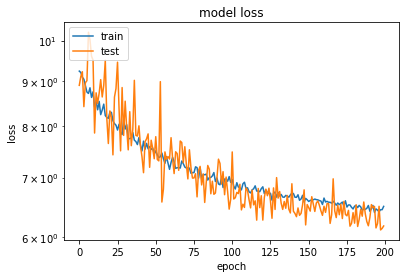

## MODEL SAVED ##


In [39]:
mi_cvae.train(input_cvae, output_cvae, epochs= 200, verbose=0,
              batch_size=batch_size, callbacks=[histinfo])

In [40]:
cond_emb = mi_cvae.cond_embedding.predict(input_cvae[1:])

Mutual Information Gap : 0.05


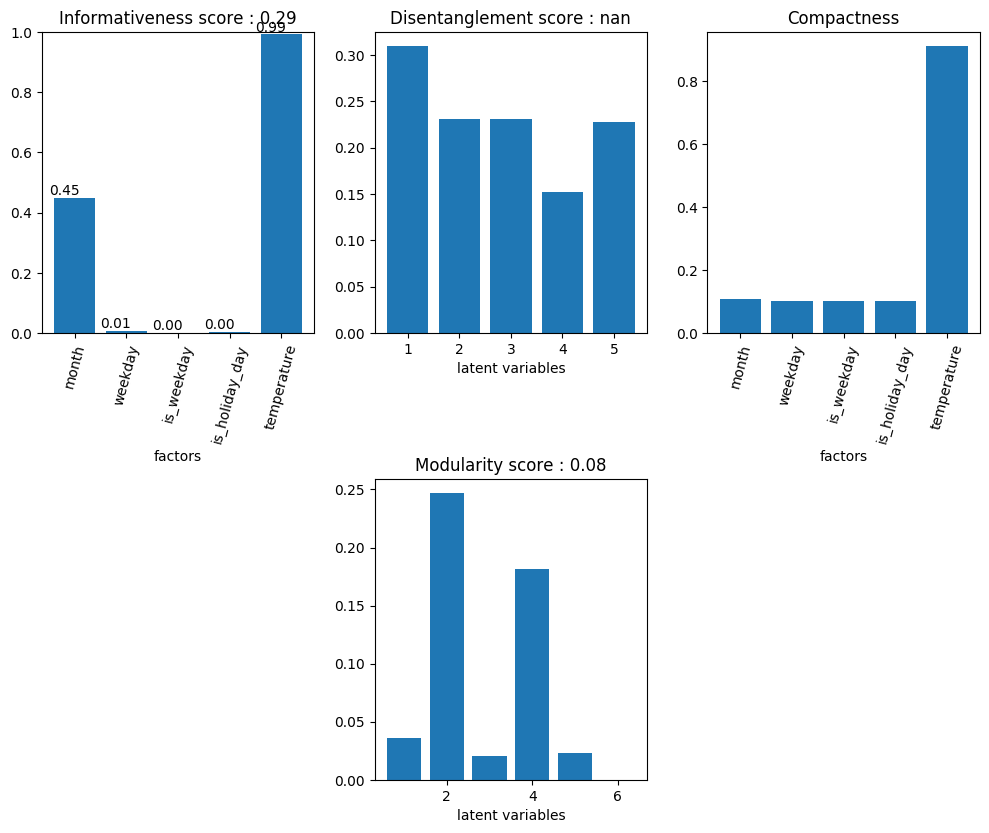

In [41]:
model_eval, importanceMatrix = evaluate_latent_code(cond_emb, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, cond_emb.shape[1], factorDesc)

In [42]:
mi_cvae.maketrainable(modelpart=['decoder'], boolean=True)
mi_cvae.maketrainable(modelpart=['cond_embedding'], boolean=False)
for lay in mi_cvae.decoder.get_layer("cond_emb").layers:
    print(lay.trainable)
for lay in mi_cvae.encoder.layers:
    print(lay.trainable)

Change trainable status of decoder layers
Change trainable status of cond_embedding layers
False
False
False
False
False
False
False
True
True
True
False
True
True
True


## START TRAINING ##
Mutual informations for epoch 253 are XZ :  5.956 ; X(C+Z) :  145.431 ; CZ :  12.336 ; CEmb :  8.720 ; XX' :  38.629
Mutual informations for epoch 258 are XZ :  6.226 ; X(C+Z) :  145.396 ; CZ :  11.335 ; CEmb :  8.720 ; XX' :  40.900
Mutual informations for epoch 263 are XZ :  6.165 ; X(C+Z) :  145.356 ; CZ :  10.347 ; CEmb :  8.720 ; XX' :  42.416
Mutual informations for epoch 268 are XZ :  6.014 ; X(C+Z) :  145.318 ; CZ :  9.416 ; CEmb :  8.720 ; XX' :  45.350
Mutual informations for epoch 273 are XZ :  5.729 ; X(C+Z) :  145.270 ; CZ :  8.448 ; CEmb :  8.720 ; XX' :  45.046
Mutual informations for epoch 278 are XZ :  5.311 ; X(C+Z) :  145.215 ; CZ :  7.447 ; CEmb :  8.720 ; XX' :  45.622
Mutual informations for epoch 283 are XZ :  4.839 ; X(C+Z) :  145.162 ; CZ :  6.534 ; CEmb :  8.720 ; XX' :  44.747
Mutual informations for epoch 289 are XZ :  4.261 ; X(C+Z) :  145.141 ; CZ :  5.687 ; CEmb :  8.720 ; XX' :  48.162
Mutual informations for epoch 294 are XZ :  3.74

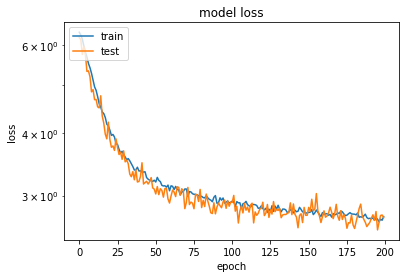

## MODEL SAVED ##


In [43]:
mi_cvae.train(input_cvae, output_cvae, epochs= 200, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop, histinfo])

Mutual Information Gap : 0.10


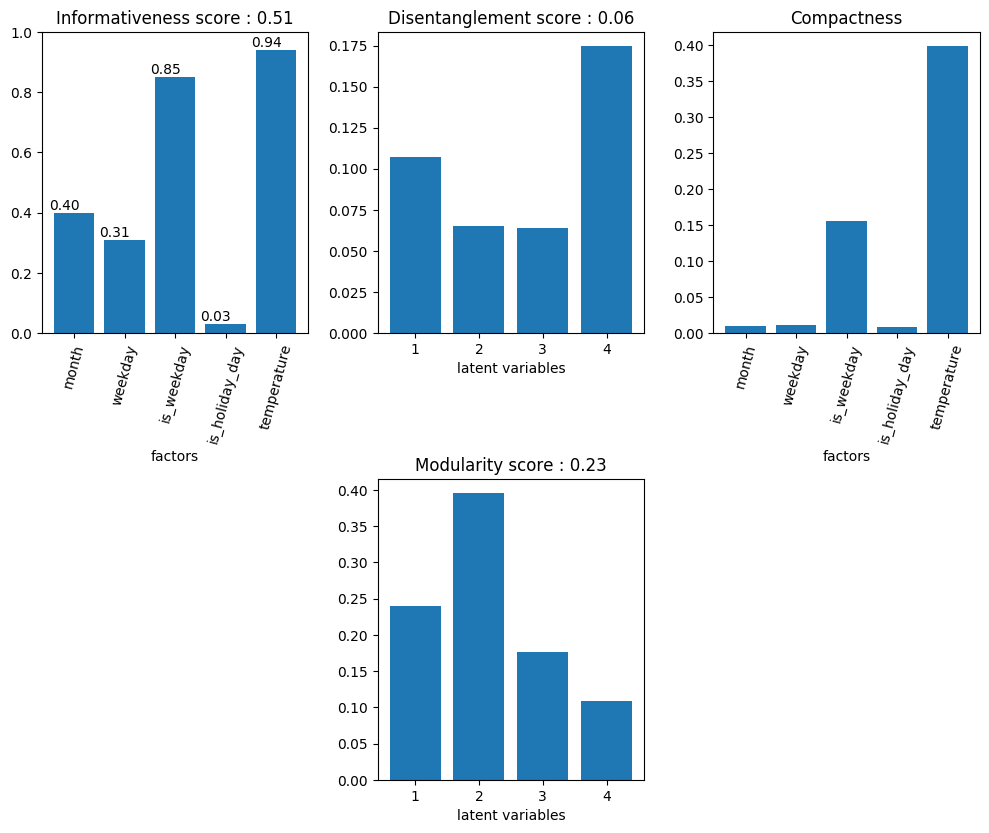

In [44]:
x_encoded = mi_cvae.encoder.predict(input_cvae)[0]
model_eval, importanceMatrix =evaluate_latent_code(x_encoded, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, z_dim, factorDesc)

In [45]:
#mi_cvae.save()
loss_weights = {"recon_loss" : 1, "kl_loss" : 0.67, "info_loss" : 66, "mutualinfo_loss":1}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=None,
                             options={"prior_mu":0., "log_prior_sigma":0., "kl_annealing":0., "alpha":1.01, "scale":sop, "kappa":1.})
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5
vae_params.training_params.log_prior_sigma = [-2.,-1.,0.,1.]


In [46]:
mi_cvae.load_model(retrieve_model_architecture=True, training_params=vae_params.training_params)

Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003
Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_inputs (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_0 (InputLayer)     [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_1 (InputLayer)     [(None, 12)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          10230       ['x_inputs[0][0]',              

Losses and associated weight involved in the model: 
recon_loss  :  1
kl_loss  :  0.67
info_loss  :  66
mutualinfo_loss  :  1


## START TRAINING ##


2021-12-13 16:57:04.435318: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7254660


Mutual informations for epoch 458 are XZ :  0.988 ; X(C+Z) :  144.960 ; CZ :  2.692 ; CEmb :  9.057 ; XX' :  53.707
Mutual informations for epoch 467 are XZ :  0.986 ; X(C+Z) :  144.977 ; CZ :  2.653 ; CEmb :  9.114 ; XX' :  53.134
Mutual informations for epoch 475 are XZ :  0.989 ; X(C+Z) :  144.981 ; CZ :  2.625 ; CEmb :  9.161 ; XX' :  54.917
Mutual informations for epoch 484 are XZ :  1.011 ; X(C+Z) :  144.987 ; CZ :  2.684 ; CEmb :  9.148 ; XX' :  54.657
Mutual informations for epoch 493 are XZ :  0.991 ; X(C+Z) :  144.980 ; CZ :  2.669 ; CEmb :  9.126 ; XX' :  55.896
Mutual informations for epoch 502 are XZ :  0.994 ; X(C+Z) :  144.979 ; CZ :  2.676 ; CEmb :  9.134 ; XX' :  54.557
Mutual informations for epoch 512 are XZ :  1.029 ; X(C+Z) :  144.985 ; CZ :  2.763 ; CEmb :  9.173 ; XX' :  56.416
Mutual informations for epoch 521 are XZ :  1.008 ; X(C+Z) :  144.974 ; CZ :  2.754 ; CEmb :  9.207 ; XX' :  55.367
Mutual informations for epoch 531 are XZ :  0.979 ; X(C+Z) :  144.976 ; 

Mutual informations for epoch 1668 are XZ :  -3.306 ; X(C+Z) :  144.651 ; CZ :  0.576 ; CEmb :  14.027 ; XX' :  73.541
Mutual informations for epoch 1700 are XZ :  -3.526 ; X(C+Z) :  144.667 ; CZ :  0.479 ; CEmb :  14.028 ; XX' :  74.272
Mutual informations for epoch 1731 are XZ :  -3.735 ; X(C+Z) :  144.685 ; CZ :  0.409 ; CEmb :  14.141 ; XX' :  74.723
Mutual informations for epoch 1763 are XZ :  -3.914 ; X(C+Z) :  144.702 ; CZ :  0.333 ; CEmb :  14.158 ; XX' :  74.859
Mutual informations for epoch 1796 are XZ :  -4.047 ; X(C+Z) :  144.743 ; CZ :  0.226 ; CEmb :  14.261 ; XX' :  74.397
Mutual informations for epoch 1830 are XZ :  -4.225 ; X(C+Z) :  144.766 ; CZ :  0.119 ; CEmb :  14.248 ; XX' :  76.063
Mutual informations for epoch 1864 are XZ :  -4.392 ; X(C+Z) :  144.792 ; CZ :  -0.009 ; CEmb :  14.181 ; XX' :  75.504
Mutual informations for epoch 1899 are XZ :  -4.633 ; X(C+Z) :  144.820 ; CZ :  -0.143 ; CEmb :  14.167 ; XX' :  75.930
Mutual informations for epoch 1934 are XZ :  -

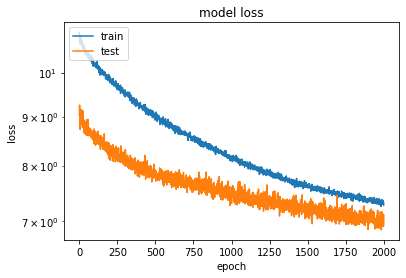

## MODEL SAVED ##


In [47]:
mi_cvae.train(input_cvae, output_cvae, epochs= 2000, verbose=0,
              batch_size=128, callbacks=[earl_stop, histinfo])

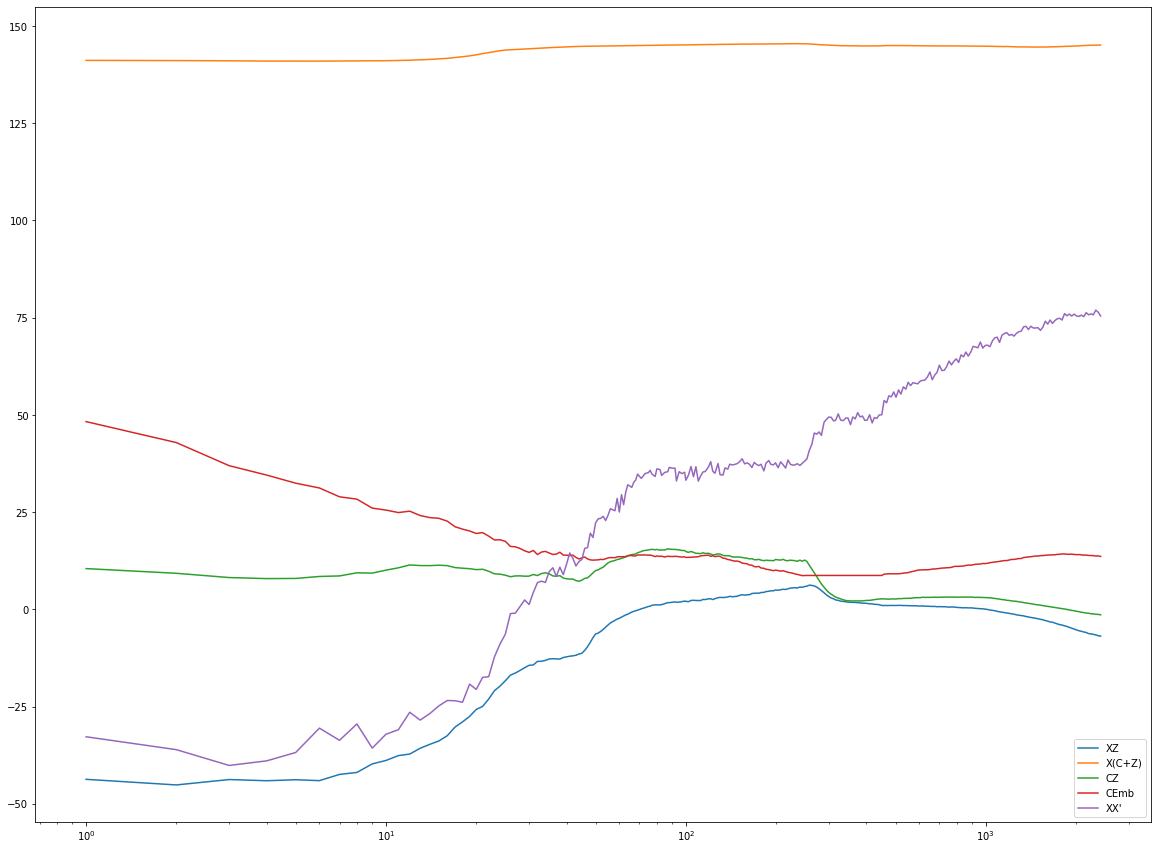

In [48]:
plt.figure(figsize=(20,15))
for key, list_val in histinfo.MI.items():
    plt.plot(histinfo.period[:len(list_val)], list_val, label=key)
plt.xscale("log")
plt.legend()

In [69]:
x_encoded = mi_cvae.encoder.predict(input_cvae)[0]

Mutual Information Gap : 0.08


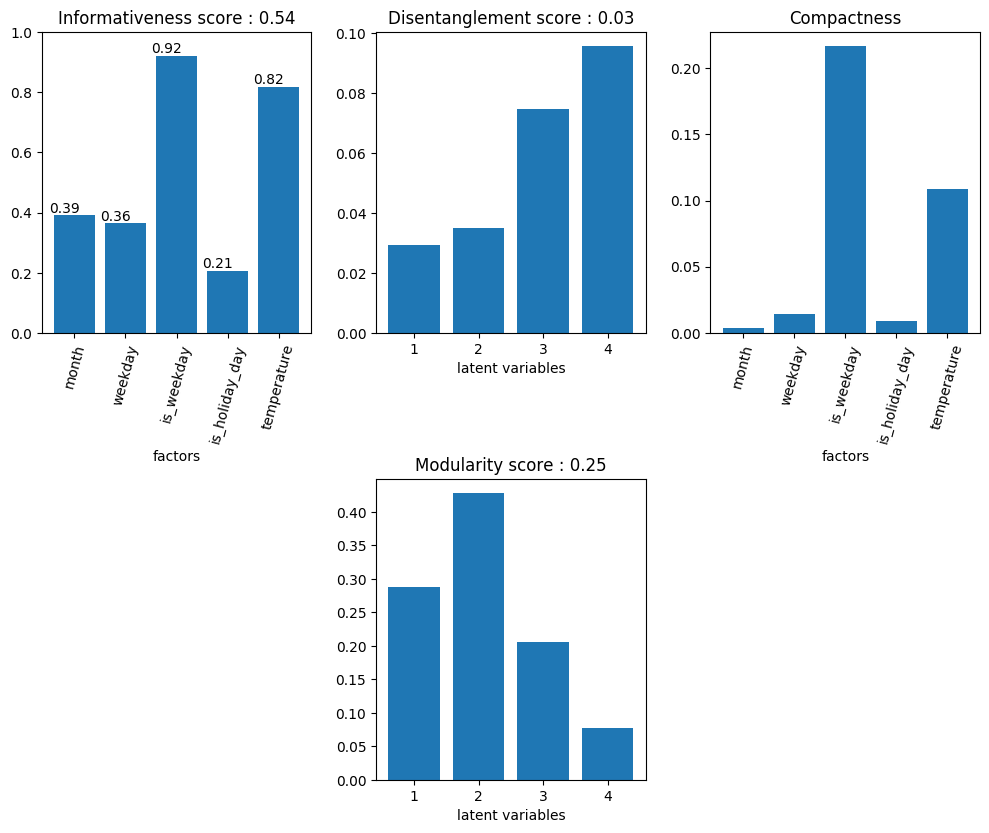

In [70]:
model_eval, importanceMatrix = evaluate_latent_code(x_encoded, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, z_dim, factorDesc)

In [71]:
test_input_cvae = [df_conso.values[test_set,:]] + [c[test_set,:] for c in condarray]

x_hat = new_cae.model.predict(test_input_cvae)

np.mean(np.abs(x_hat - test_input_cvae[0]))

0.8910851431830702